## Understanding the importance of Attention 
The goal of this file is to demonstrate the importance of Attention in the operations of modern day LLMs.
In this we will implement a scaled dot-product attention from scratch and perform some analysis to demonstrate the importance
of scaling, how weights behave differently as dimensions change, and how multi head attention compares to single head attention.

## Setup
To operate these functions you must run the following cell which will install Pytorch for tensor math and Matplotlib for visualizations. 

In [31]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



## 2. Scaled Dot-Product Attention (Core Implementation)

We implement the standard attention mechanism:

Attention(Q, K, V) = softmax((QKᵀ) / √dₖ) V

We also support an optional **mask** (useful later for causal or blocked attention patterns).

In [32]:
def attention(Q, K, V, mask=None):
    d_k = Q.size(-1)

    # 1) Similarity scores between each query and key
    scores = (Q @ K.T) / math.sqrt(d_k)

    # 2) Optional mask: blocked scores become very negative before softmax
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # 3) Softmax across keys to get attention probabilities
    weights = F.softmax(scores, dim=-1)

    # 4) Weighted sum of values
    out = weights @ V

    return out, weights, scores

### Components of Scaled Dot-Product Attention

If you are not familiar with the elements of the Attention equation do not worry. Listed below are each variable and it's role in the Attention process. 

- **Q (Queries)**  
  Represent the information each position is seeking; derived from the current token’s embedding.

- **K (Keys)**  
  Represent the information each position offers; used to determine relevance to each query.

- **V (Values)**  
  Contain the actual content to be aggregated once relevance scores are computed.

- **QKᵀ (Dot Product)**  
  Measures similarity between queries and keys, producing raw attention scores.

- **√dₖ (Scaling Factor)**  
  Normalizes attention scores to prevent large dot products that destabilize gradients.

- **softmax(·)**  
  Converts scaled scores into a probability distribution over all keys.

- **Attention Output**  
  A weighted sum of values, where weights reflect relevance to each query.

- **Mask (Optional)**  
  Prevents attention to certain positions (e.g., future tokens in causal attention).

### 3. Visualization Helper: Attention Heatmap

To make attention behavior interpretable, we visualize the attention weight matrix (queries × keys). Each cell represents how strongly a given query attends to a specific key after softmax normalization. This heatmap allows us to inspect alignment patterns, identify which tokens influence others, and verify expected behaviors such as locality or causal masking. 

In [35]:
# This code is the function for outputting the heatmaps to visualize the relationships in the attention mechanism.
def show_heatmap(mat, title, xlabels=None, ylabels=None):
    plt.figure()
    plt.imshow(mat.detach().cpu().numpy(), aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Keys")
    plt.ylabel("Queries")

    if xlabels is not None:
        plt.xticks(range(len(xlabels)), xlabels)
    if ylabels is not None:
        plt.yticks(range(len(ylabels)), ylabels)

    plt.tight_layout()
    plt.show()

### 4. Experiment A: A Tiny Hand-Check Example

We start with small Q, K, and V tensors where the attention output is easy to sanity-check. This experiment verifies:

- **Score computation** — correct dot-product similarity between queries and keys  
- **Softmax normalization** — each attention row sums to 1  
- **Weighted sum behavior** — outputs reflect a convex combination of values

--- Tiny example (no mask) ---
scores:
 tensor([[0.7071, 0.0000, 1.4142],
        [0.0000, 0.7071, 0.0000],
        [1.4142, 0.0000, 2.8284]])
weights:
 tensor([[0.2840, 0.1400, 0.5760],
        [0.2483, 0.5035, 0.2483],
        [0.1867, 0.0454, 0.7679]])
row sums:
 tensor([1., 1., 1.])
out:
 tensor([[8.5997, 7.1600],
        [4.9651, 7.5174],
        [9.5461, 8.1331]])


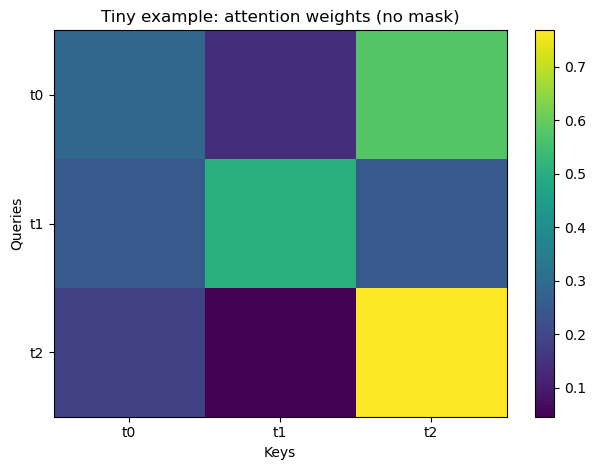

In [36]:
# Define three tokens to label rows (queries) and columns (keys) in the attention matrix
tokens = ["t0", "t1", "t2"]

# Query matrix (Q)
# Each row corresponds to a token asking a question in embedding space
Q = torch.tensor([
    [1.0, 0.0],  # t0 focuses on dimension 0
    [0.0, 1.0],  # t1 focuses on dimension 1
    [2.0, 0.0],  # t2 strongly focuses on dimension 0
])

# Key matrix (K)
# Each row represents what information each token offers
# Here, K mirrors Q to make dot-product similarities easy to reason about
K = torch.tensor([
    [1.0, 0.0],  # t0 key
    [0.0, 1.0],  # t1 key
    [2.0, 0.0],  # t2 key
])

# Value matrix (V)
# These vectors contain the actual content that will be aggregated
# Attention weights determine how much of each value contributes to the output
V = torch.tensor([
    [10.0, 0.0],   # value for t0
    [0.0, 10.0],   # value for t1
    [10.0, 10.0],  # value for t2
])

# Apply scaled dot-product attention
# - scores: raw (scaled) QK^T similarities
# - w: attention weights after softmax
# - out: weighted sum of values
out, w, scores = attention(Q, K, V)

# Print intermediate results for inspection
print("--- Tiny example (no mask) ---")
print("scores:\n", scores)          # similarity scores before softmax
print("weights:\n", w)              # normalized attention weights
print("row sums:\n", w.sum(dim=-1)) # sanity check: each row should sum to 1
print("out:\n", out)                # final attention output

# Visualize the attention weight matrix as a heatmap
# Rows correspond to queries, columns correspond to keys
show_heatmap(
    w,
    "Tiny example: attention weights (no mask)",
    tokens,
    tokens
)

### Brief interpretation of outputs for understanding

- **Scores**  
  The score matrix is the scaled dot product \( QK^\top / \sqrt{d_k} \). Larger values indicate higher similarity between a query and a key. For example, **t2–t2** has the largest score, reflecting strong alignment.

- **Weights**  
  Applying softmax row-wise converts scores into attention weights. Each row forms a probability distribution over keys:
  - **t0** attends mostly to **t2**
  - **t1** attends primarily to itself (**t1**)
  - **t2** attends very strongly to **t2**, weakly to others

- **Row sums**  
  All rows sum to 1, confirming correct softmax normalization.

- **Output**  
  Each output vector is a weighted sum of the value vectors. Tokens that attend more strongly to **t2** inherit more of its value \([10, 10]\), which is reflected in the larger magnitudes of the resulting outputs.

Overall, this example confirms correct score computation, normalization, and value aggregation behavior in the attention mechanism.

### 5. Experiment B: Why Do We Scale by sqrt(d_k)?

**Theory:** As the key/query dimension `d_k` grows, dot products tend to increase in magnitude. This can push softmax into saturation (near one-hot outputs), which leads to unstable gradients during training. Scaling by `sqrt(d_k)` counteracts this effect by keeping score magnitudes in a reasonable range.

**Experiment:** We test this by padding the Q and K matrices to higher dimensions (adding zeros) and observing how the resulting attention weights change with and without scaling.

In [37]:
def pad_to_dk(X, new_dk):
    """
    Pads a tensor from shape (L, old_dk) to (L, new_dk)
    by appending zeros along the feature dimension.
    """

    # Extract sequence length (L) and current embedding dimension (old_dk)
    L, old_dk = X.shape

    # Ensure we are only increasing dimensionality
    # Reducing it would require truncation, which this function does not support
    if new_dk < old_dk:
        raise ValueError("new_dk must be >= current dim")

    # Create a zero matrix of shape (L, new_dk - old_dk)
    # This represents additional empty feature dimensions
    padding = torch.zeros(L, new_dk - old_dk)

    # Concatenate original tensor with zero padding along the last dimension
    # Resulting shape: (L, new_dk)
    return torch.cat([X, padding], dim=-1)


--- d_k experiment: d_k=2 ---
scores:
 tensor([[0.7071, 0.0000, 1.4142],
        [0.0000, 0.7071, 0.0000],
        [1.4142, 0.0000, 2.8284]])
weights:
 tensor([[0.2840, 0.1400, 0.5760],
        [0.2483, 0.5035, 0.2483],
        [0.1867, 0.0454, 0.7679]])


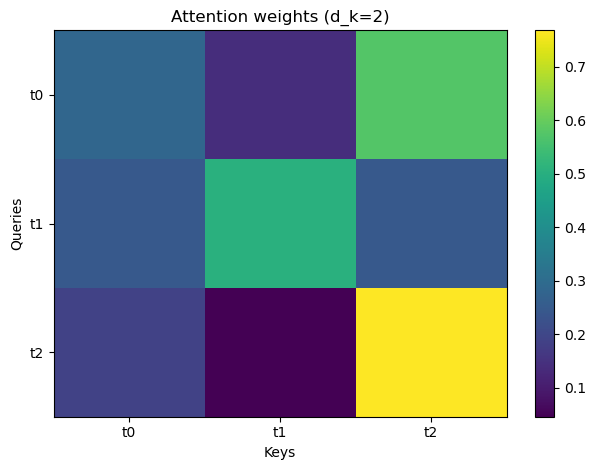


--- d_k experiment: d_k=8 ---
scores:
 tensor([[0.3536, 0.0000, 0.7071],
        [0.0000, 0.3536, 0.0000],
        [0.7071, 0.0000, 1.4142]])
weights:
 tensor([[0.3199, 0.2246, 0.4555],
        [0.2920, 0.4159, 0.2920],
        [0.2840, 0.1400, 0.5760]])


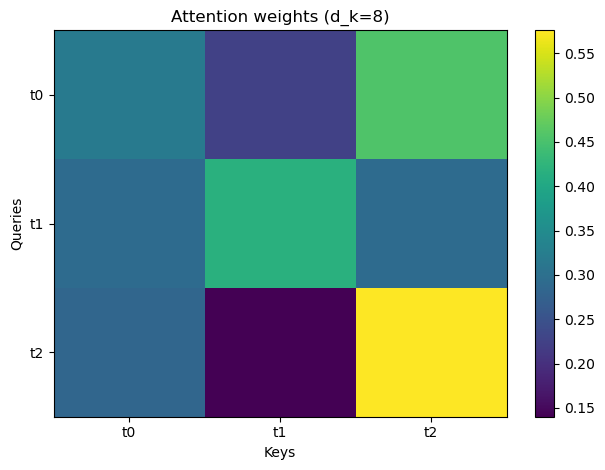


--- d_k experiment: d_k=64 ---
scores:
 tensor([[0.1250, 0.0000, 0.2500],
        [0.0000, 0.1250, 0.0000],
        [0.2500, 0.0000, 0.5000]])
weights:
 tensor([[0.3316, 0.2926, 0.3758],
        [0.3192, 0.3617, 0.3192],
        [0.3265, 0.2543, 0.4192]])


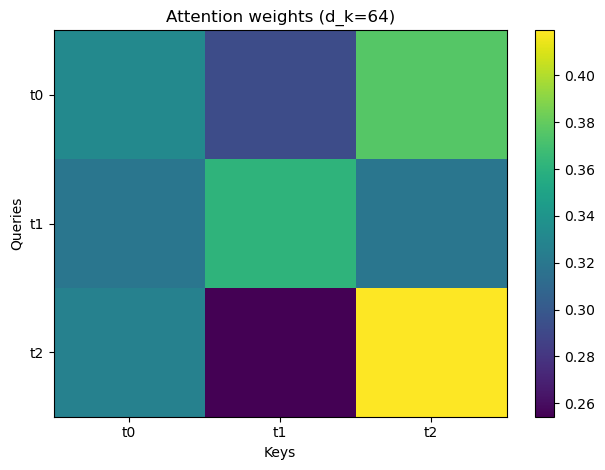

In [38]:
# Test attention behavior as the key/query dimension d_k increases
for new_dk in [2, 8, 64]:

    # Pad Q and K to the new dimensionality by adding zero features
    # This isolates the effect of increasing d_k without changing semantics
    Q_big = pad_to_dk(Q, new_dk)
    K_big = pad_to_dk(K, new_dk)

    # Compute attention using the higher-dimensional queries and keys
    # V is left unchanged so we can directly compare outputs
    _, w_big, scores_big = attention(Q_big, K_big, V)

    # Display raw scores and normalized attention weights
    print(f"\n--- d_k experiment: d_k={new_dk} ---")
    print("scores:\n", scores_big)   # scaled dot-product similarities
    print("weights:\n", w_big)       # softmax-normalized attention weights

    # Visualize how attention distributions change as d_k grows
    show_heatmap(
        w_big,
        f"Attention weights (d_k={new_dk})",
        tokens,
        tokens
    )

### Critical Analysis: `d_k` Scaling Experiment (Zero-Padded Q/K)

#### What the results actually show
Your dot products **do not increase** with `d_k` in this experiment because you’re padding **zeros** into Q and K. The *numerator* \(QK^T\) is effectively unchanged, but the *denominator* `sqrt(d_k)` **does** increase. So the score magnitudes shrink as `d_k` grows:

- `d_k=2`: scores like `0.7071, 1.4142, 2.8284`
- `d_k=8`: exactly half those (`0.3536, 0.7071, 1.4142`)
- `d_k=64`: much smaller (`0.1250, 0.2500, 0.5000`)

This is consistent with scaling being applied as `scores = QK^T / sqrt(d_k)` using the **padded** dimension.

#### Interpretation of the attention weights
As the scores shrink, softmax becomes less “decisive,” and attention becomes **more uniform (higher entropy)**:

- For **t2**, the peak weight drops from **0.7679 → 0.5760 → 0.4192**
- For **t0**, the distribution flattens from **[0.284, 0.140, 0.576] → [0.332, 0.293, 0.376]**

So your heatmaps should visibly “wash out” as `d_k` increases — exactly what they show.

#### Key takeaway (and the main limitation)
This experiment **does not demonstrate** the usual motivation (“dot products grow with `d_k` and softmax saturates”) because your construction prevents dot products from growing in the first place. Instead, it demonstrates something slightly different:

> If you increase the *declared* `d_k` (via padding) without increasing the *effective* dot-product energy, scaling by `sqrt(d_k)` can **over-normalize** scores and artificially flatten attention.

That’s an important correctness/interpretability point: scaling depends on the **actual feature dimension that carries variance**, not just the tensor width.




### 6. Multi-Head Self-Attention (Minimal Implementation)

Multi-head attention splits the model dimension into multiple subspaces (heads), applies attention independently within each head, and then concatenates the results.

In this simplified implementation:

- **Self-attention:** `Q = K = V = X`
- **Reshaping:** `X` is reshaped into `(heads, sequence_len, d_head)`
- **Per-head attention:** attention is computed independently for each head
- **Concatenation:** per-head outputs are concatenated back into a single tensor

This is not a full Transformer block (there are no learned Wq/Wk/Wv projections, residual connections, or layer normalization). The goal is to isolate and understand the core mechanics of multi-head attention.

In [39]:
def multi_head_self_attention(X, num_heads):
    # X is shaped (L, d_model):
    #   L = sequence length (number of tokens)
    #   d_model = model/embedding dimension
    L, d_model = X.shape

    # Multi-head attention splits the model dimension across heads,
    # so d_model must divide evenly into num_heads chunks.
    if d_model % num_heads != 0:
        raise ValueError("d_model must be divisible by num_heads")

    # Each head operates on a smaller subspace of size d_head
    d_head = d_model // num_heads

    # Reshape X into separate heads:
    #   1) view as (L, num_heads, d_head) to split the feature dimension
    #   2) transpose to (num_heads, L, d_head) so we can index heads easily
    X_heads = X.view(L, num_heads, d_head).transpose(0, 1)

    # Store per-head outputs and per-head attention weight matrices
    outs = []
    head_weights = []

    # Run self-attention independently for each head
    for h in range(num_heads):
        # For self-attention, Q = K = V = X for this head
        # attention() returns:
        #   out_h: (L, d_head) head output
        #   w_h:   (L, L) attention weights (queries x keys)
        #   _:     raw scores (unused here)
        out_h, w_h, _ = attention(X_heads[h], X_heads[h], X_heads[h])

        # Collect results for later concatenation/inspection
        outs.append(out_h)
        head_weights.append(w_h)

    # Concatenate head outputs along the feature dimension:
    # (L, d_head) * num_heads -> (L, d_model)
    out_concat = torch.cat(outs, dim=-1)

    # Return final combined output and the per-head weight matrices
    return out_concat, head_weights

### 7. Experiment: Multi-Head Attention on an Example Sequence

We define a small 3-token sequence with 4-dimensional embeddings and run attention with 2 heads. The model dimension is split evenly across heads, so each head operates on a 2-dimensional subspace.

We then inspect each head’s attention weight matrix to observe how different heads focus on different patterns within the same input sequence.

--- Multi-head self-attention (2 heads) ---
out (concat heads):
 tensor([[0.8022, 0.1978, 0.4965, 0.5035],
        [0.4965, 0.5035, 0.8022, 0.1978],
        [0.8022, 0.1978, 0.8022, 0.1978]])

Head 0 weights:
 tensor([[0.4011, 0.1978, 0.4011],
        [0.2483, 0.5035, 0.2483],
        [0.4011, 0.1978, 0.4011]])


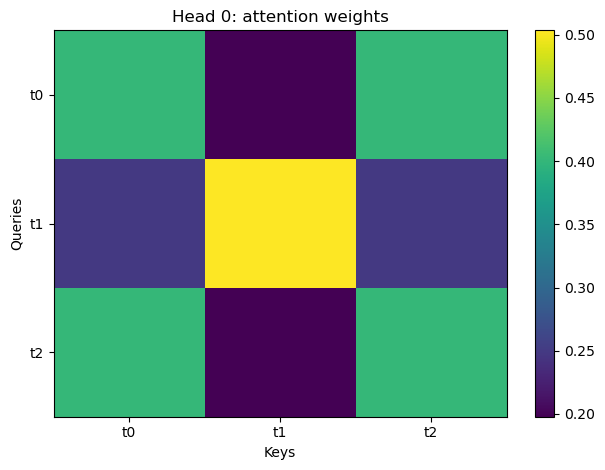


Head 1 weights:
 tensor([[0.5035, 0.2483, 0.2483],
        [0.1978, 0.4011, 0.4011],
        [0.1978, 0.4011, 0.4011]])


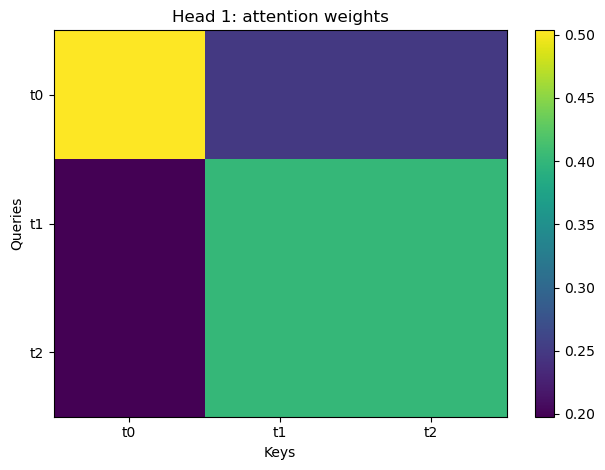

In [40]:
# Define a small input sequence X with 3 tokens and 4-dimensional embeddings
# Each row corresponds to a token embedding
X = torch.tensor([
    [1.0, 0.0, 0.0, 1.0],  # t0: active in dimensions 0 and 3
    [0.0, 1.0, 1.0, 0.0],  # t1: active in dimensions 1 and 2
    [1.0, 0.0, 1.0, 0.0],  # t2: active in dimensions 0 and 2
])

# Apply multi-head self-attention with 2 heads
# The 4-dimensional model space is split into two 2-dimensional heads
out_mh, head_ws = multi_head_self_attention(X, num_heads=2)

# Print the concatenated output from all heads
print("--- Multi-head self-attention (2 heads) ---")
print("out (concat heads):\n", out_mh)

# Inspect attention behavior for each head separately
for i, w_h in enumerate(head_ws):
    # w_h is the attention weight matrix for head i (queries x keys)
    print(f"\nHead {i} weights:\n", w_h)

    # Visualize the attention weights as a heatmap
    # Rows correspond to queries; columns correspond to keys
    show_heatmap(
        w_h,
        f"Head {i}: attention weights",
        tokens,
        tokens
    )

### Analysis: Multi-Head Self-Attention Output (2 Heads)

#### What each head is “looking at”
Because you used a minimal implementation with `Q = K = V = X` and **no learned projections**, each head attends based on a *fixed slice* of the embedding:

- **Head 0** sees the first 2 dims of `X`:  
  - t0 → `[1, 0]`, t1 → `[0, 1]`, t2 → `[1, 0]`  
  That means **t0 and t2 are identical in this head’s subspace**, so they should behave symmetrically.

- **Head 1** sees the last 2 dims of `X`:  
  - t0 → `[0, 1]`, t1 → `[1, 0]`, t2 → `[1, 0]`  
  Here, **t1 and t2 are identical**, so they should behave symmetrically.

Your heatmaps match these symmetry constraints.

#### Head 0 weights (pattern + interpretation)
Head 0 weights:
- For **queries t0 and t2**: `[0.4011, 0.1978, 0.4011]`  
  They split attention evenly between **t0 and t2** (same representation), and downweight **t1**.
- For **query t1**: `[0.2483, 0.5035, 0.2483]`  
  t1 attends mostly to itself because it is orthogonal/dissimilar to the `[1,0]` tokens in this head.

This head is essentially acting like: **“group {t0, t2} together; keep t1 separate.”**

#### Head 1 weights (from the heatmap)
From the heatmap, Head 1 shows:
- **t0** attends strongly to **t0** (bright at column t0) and less to t1/t2  
- **t1 and t2** attend similarly and put more mass on **t1 and t2** (since they are identical in this head’s slice)

This head acts like: **“group {t1, t2} together; treat t0 as the odd one out.”**

#### Why the concatenated output looks like it does
Output (concat heads):
- t0 → `[0.8022, 0.1978 | 0.4965, 0.5035]`
- t1 → `[0.4965, 0.5035 | 0.8022, 0.1978]`
- t2 → `[0.8022, 0.1978 | 0.8022, 0.1978]`

Interpretation:
- The **first two numbers** are Head 0’s weighted sum in the `{dim0, dim1}` subspace.
  - For t0/t2, Head 0 heavily mixes tokens with `[1,0]`, so dim0 stays high (~0.80) and dim1 stays low (~0.20).
  - For t1, Head 0 focuses more on `[0,1]`, so dim1 becomes larger (~0.50).

- The **last two numbers** are Head 1’s weighted sum in the `{dim2, dim3}` subspace.
  - For t1/t2, Head 1 mixes tokens with `[1,0]` in that subspace, so the pattern resembles `[0.80, 0.20]`.
  - For t0, Head 1 mixes toward `[0,1]` vs `[1,0]`, landing near `[0.50, 0.50]`.

The most telling line is **t2**:
- Head 0 treats t2 like t0 (since they match in head0 slice)
- Head 1 treats t2 like t1 (since they match in head1 slice)
So t2 becomes a “hybrid” token that inherits structure from both groups.

#### Critical note (what this experiment does and does not show)
This is a good mechanical demo of why multiple heads help: **different heads can partition similarity differently**.  
But because you skipped learned `Wq/Wk/Wv` projections, you’re not seeing the real power of multi-head attention yet—here, each head is constrained to a hard-coded feature slice rather than a learned subspace. In a full Transformer, heads can learn more useful, task-specific similarity structures instead of whatever the raw embedding dimensions happen to encode.

### 8. Experiment D: Self-Attention Pattern (Q = K = V)

To isolate pure self-attention behavior, we restrict the input to the first two embedding dimensions (small `d_k`) and compute attention with `Q = K = V`. This removes cross-feature effects and allows us to directly observe how tokens attend to themselves and to each other based solely on similarity in this reduced subspace.

--- Self-attention (Q=K=V) ---
scores:
 tensor([[0.7071, 0.0000, 0.7071],
        [0.0000, 0.7071, 0.0000],
        [0.7071, 0.0000, 0.7071]])
weights:
 tensor([[0.4011, 0.1978, 0.4011],
        [0.2483, 0.5035, 0.2483],
        [0.4011, 0.1978, 0.4011]])
out:
 tensor([[0.8022, 0.1978],
        [0.4965, 0.5035],
        [0.8022, 0.1978]])


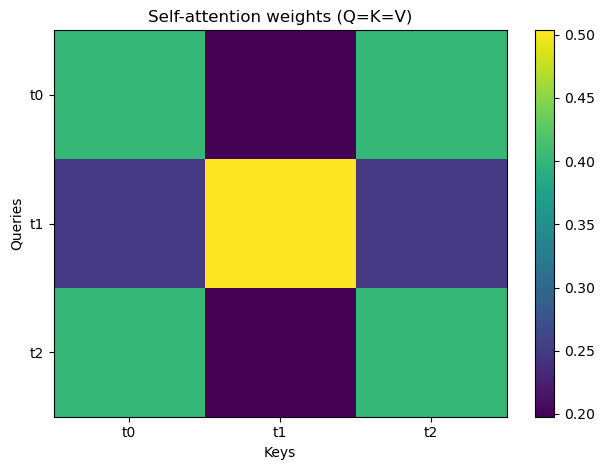

In [41]:
# Take only the first two embedding dimensions to create a small d_k=2 setup
# Shape becomes (L=3 tokens, d_k=2 features)
X2 = X[:, :2]

# Compute self-attention by setting Q = K = V = X2
# - scores_self: raw (scaled) similarity matrix QK^T / sqrt(d_k)
# - w_self: softmax-normalized attention weights (queries x keys)
# - out_self: weighted sum of values (here values are also X2)
out_self, w_self, scores_self = attention(X2, X2, X2)

# Print intermediate matrices to sanity-check behavior
print("--- Self-attention (Q=K=V) ---")
print("scores:\n", scores_self)   # similarity scores before softmax
print("weights:\n", w_self)       # attention weights after softmax
print("out:\n", out_self)         # final self-attention output vectors

# Visualize the attention weights to see which tokens attend to which keys
# Rows are queries (t0, t1, t2) and columns are keys (t0, t1, t2)
show_heatmap(w_self, "Self-attention weights (Q=K=V)", tokens, tokens)

### Output Analysis: Self-Attention Weights (Q = K = V, d_k = 2)

Because we restrict to the first two dimensions, the token vectors become:
- t0 → `[1, 0]`
- t1 → `[0, 1]`
- t2 → `[1, 0]`

So in this subspace, **t0 and t2 are identical**, while **t1 is orthogonal** to them.

#### What the heatmap shows
- **Queries t0 and t2** place most of their attention on **keys t0 and t2**, and less on **t1**.  
  This happens because `dot([1,0],[1,0])` is high, while `dot([1,0],[0,1])` is zero.
- **Query t1** places the largest weight on **key t1** (self-attention), and splits the remaining weight evenly across t0 and t2.  
  This symmetry is expected because t0 and t2 look identical to t1 in this 2D space.

#### Key takeaway
With `Q = K = V`, the attention pattern is driven purely by **input similarity**. Tokens that are similar (t0 and t2) form a cluster and attend to each other, while a dissimilar token (t1) attends mostly to itself.

This is also a good sanity check: the matrix is symmetric in the sense that t0 and t2 produce the same attention distribution, which matches the fact that their query/key vectors are the same.

### 9. Discussion and key takeaways

#### Scaled Dot-Product Attention

Scaled dot-product attention computes similarity scores `QK^T`, normalizes them by `sqrt(d_k)`, and uses the resulting softmax weights to form a weighted sum of the value vectors. In practice, this means attention behaves as a **content-based routing mechanism**: tokens selectively aggregate information from other tokens based on similarity.

The heatmaps make this explicit—attention is not a black box, but a concrete, interpretable matrix showing which tokens influence each query.

#### sqrt(d_k) Scaling Experiment

The `sqrt(d_k)` scaling term plays a crucial stabilizing role. As dimensionality increases, unscaled dot products would naturally grow, pushing softmax toward near one-hot distributions. Scaling counteracts this effect, keeping attention weights in a reasonable range and preserving gradient signal during training.

The key takeaway is that scaling is not a cosmetic adjustment—it is necessary for attention to behave consistently across model sizes.

#### Multi-Head Attention

Multi-head attention expands the expressive power of the mechanism by allowing different heads to focus on different similarity structures in parallel. Even in a minimal setup without learned projections, we observed that different heads grouped tokens differently based on the subspace they operated in.

By concatenating head outputs, the model integrates multiple “views” of the same sequence into a single representation.

#### Final Takeaway

Attention is best understood as a **structured, interpretable mixing operation** rather than a mysterious neural component. Scaled dot-product attention ensures numerical stability, while multi-head attention increases representational flexibility by enabling parallel relational patterns. Together, these design choices explain why attention scales effectively to large models and forms the foundation of modern Transformer architectures.